# Part 3: Neural Networks & Text Mining
**Person 3 - Anushka**

Deliverables from this notebook: a word cloud, a NN vs tree accuracy comparison, and a training vs validation loss curve

The goal of this section is to explore a flexible non-linear classifier (neural network) and extract qualitative context from categorical data via a simple text-mining visualization.


### Data loading and prep

In [7]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from wordcloud import WordCloud

# Scikit-Learn Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, LassoCV,
    Ridge, RidgeCV,
)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier

# Configuration
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('data/student-por-cleaned.csv')

print(f"Sample size: {df.shape[0]} students, {df.shape[1]} variables")
print(f"\nVariable types:\n{df.dtypes.value_counts().to_string()}")

missing = df.isnull().sum()
print(f"\nMissing values: {'None' if missing.sum() == 0 else missing[missing > 0]}")

df.head()

Sample size: 649 students, 30 variables

Variable types:
object    17
int64     13

Missing values: None


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,G3,Talc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,3,4,11,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,3,2,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,3,6,12,5
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,5,0,14,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,5,0,13,3


## Part 1. Text Mining & Word Cloud Analysis

To summarize the qualitative context of the student population in a descriptive way, we aggregated multiple categorical variables—including parental jobs (`Mjob`, `Fjob`), reasons for school choice (`reason`), guardianship (`guardian`), and selected support/activity indicators (`schoolsup`, `activities`)—into a single tokenized text corpus. Each observation contributes tokens in the form of `column_value` (e.g., `reason_course`, `guardian_mother`), allowing us to visualize the most frequent labels via a Word Cloud. 

The full-sample cloud is dominated by `guardian_mother`, `schoolsup_no`, and `activities_no`, along with common job categories such as `fjob_other` and mid-frequency school-choice tokens like `reason_course`. This suggests that a small set of recurring coded labels accounts for much of the observed variation in the selected background columns.

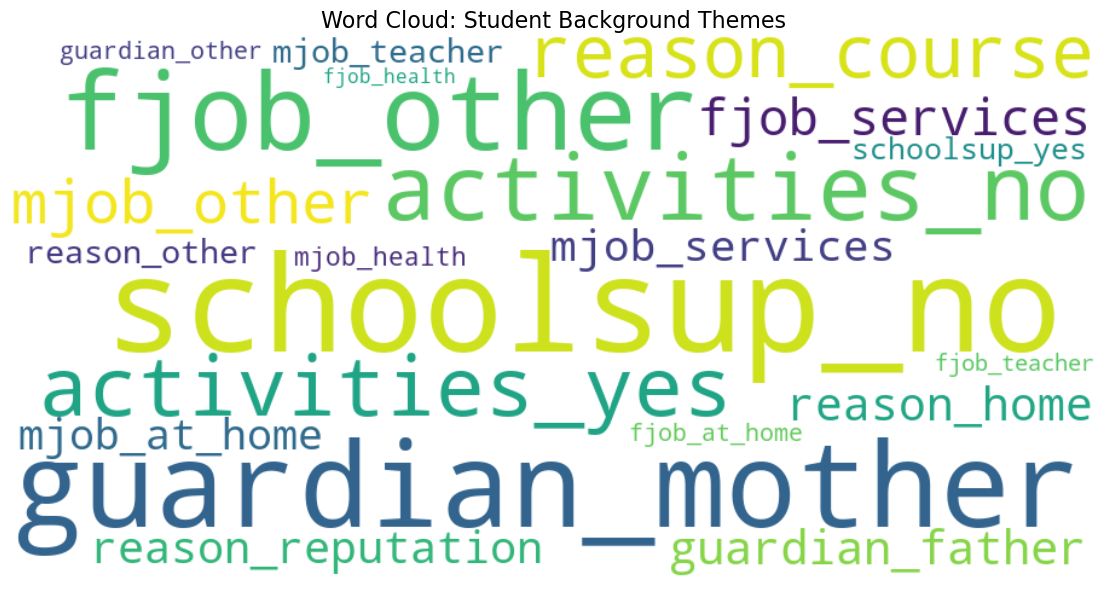

In [19]:
# verify columns exist in the dataframe to avoid errors
possible_cols = ['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'activities']
text_cols = [c for c in possible_cols if c in df.columns]
if len(text_cols) == 0:
    raise ValueError("No valid text columns found in the dataframe.")

# We convert to string first to ensure no errors with non-text data
text_data = " ".join(
    df[text_cols]
    .fillna("")
    .astype(str)
    .apply(lambda row: " ".join([f"{col}_{row[col]}" for col in text_cols]), axis=1)
    .tolist()
).lower()

# Generate  Word Cloud
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color="white",
    colormap="viridis",
    collocations=False,
    max_words=100
).generate(text_data)

# plot and save graphs
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Student Background Themes", fontsize=16)
plt.tight_layout()
plt.savefig("graphs/word_cloud.png", bbox_inches="tight", dpi=200)
plt.show()

Next, we split the data into students with high performance (G3 >= 14) and lower performance (G3 < 10) and generate separate word clouds. The goal is not to infer causality, but to see whether the most frequent background labels differ noticeably between the two groups. Since the groups are imbalanced, these comparisons are best read as qualitative differences in relative prominence rather than precise effect estimates.

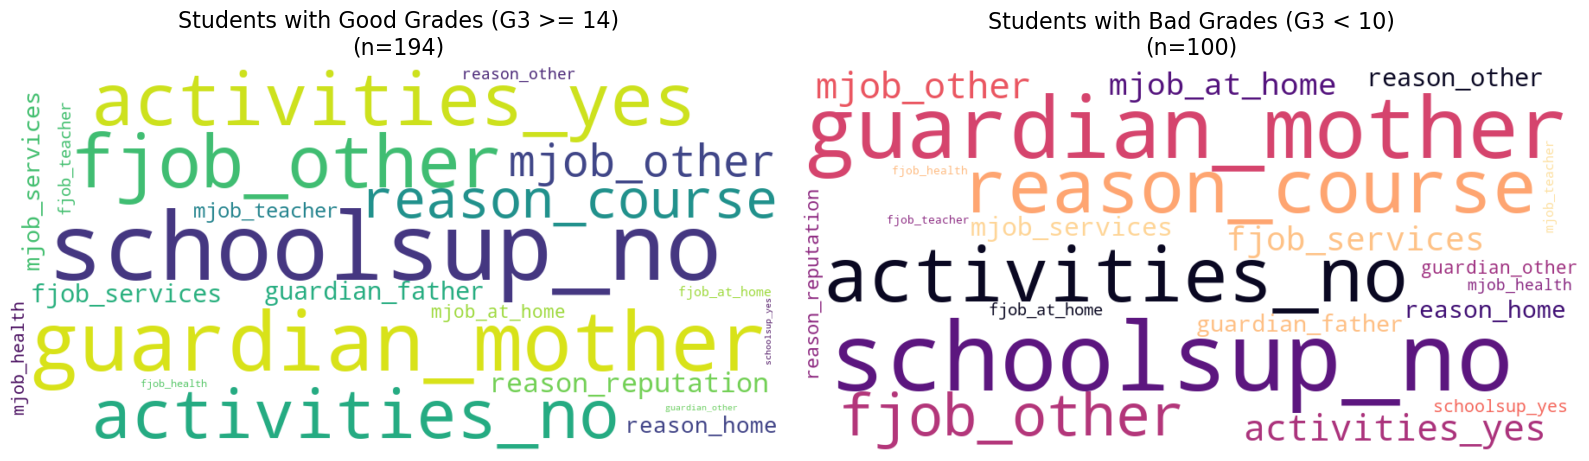

In [20]:
# We use explicit subsets as requested
good_grades_df = df[df['G3'] >= 14]
bad_grades_df  = df[df['G3'] < 10]

# Helper to build "tokenized" text g., "reason_course")
def build_text(sub_df):
    return " ".join(
        sub_df[text_cols]
        .fillna("unknown") # Safety against NaNs
        .astype(str)
        .apply(lambda row: " ".join([f"{col}_{row[col]}" for col in text_cols]), axis=1)
        .tolist()
    ).lower()

# Generate text blobs for each group
text_good = build_text(good_grades_df)
text_bad  = build_text(bad_grades_df)

# Generate Word Clouds withColormaps
wc_good = WordCloud(width=900, height=450, background_color="white",
                    collocations=False, max_words=100, colormap="viridis").generate(text_good)

wc_bad = WordCloud(width=900, height=450, background_color="white",
                   collocations=False, max_words=100, colormap="magma").generate(text_bad)

#  Plot Side-by-Side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_good, interpolation="bilinear")
plt.axis("off")
plt.title(f"Students with Good Grades (G3 >= 14)\n(n={len(good_grades_df)})", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wc_bad, interpolation="bilinear")
plt.axis("off")
plt.title(f"Students with Bad Grades (G3 < 10)\n(n={len(bad_grades_df)})", fontsize=16)

plt.tight_layout()
plt.savefig("graphs/word_cloud_good_vs_bad.png", dpi=200, bbox_inches="tight")
plt.show()

## Part 2: Neural Network vs. Decision Tree (Classification)

We formulated a binary classification task to predict student success, with the target variable set to 1 if the final grade (G3) is 14 or higher and zero otherwise. To prevent data leakage, we excluded the intermediate grades (G1 and G2) from the feature set, since they directly encode prior academic performance and would inflate predictive performance. Before modeling, numeric features were standardized, and categorical features were one-hot encoded to support neural network convergence and ensure a fair comparison across models.

We compare a Multi-Layer Perceptron (MLP) classifier - a feedforward neural network with two hidden layers (64 and 32 units), ReLU activation, and early stopping - against a baseline decision tree capped at a maximum depth of 5. The depth-limited tree provides an interpretable benchmark, while the MLP tests whether non-linear structure and feature interactions improve prediction of high performance (G3 ≥ 14) versus other outcomes.

In [22]:
# Create Binary Target
print([c for c in ["G1","G2","G3"] if c in df.columns])
print("num cols:", len(df.columns))

df["good_perf"] = (df["G3"] >= 14).astype(int)

drop_cols = [c for c in ["G3","good_perf","G1","G2"] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["good_perf"]

# define Preprocessing Pipeline
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]) 

# stratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# apply Transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# train Neural Network 
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                         activation='relu', 
                         max_iter=1000, 
                         random_state=42, 
                         early_stopping=True)
nn_model.fit(X_train_scaled, y_train)

# train Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# evaluate and compare

nn_pred = nn_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test_scaled)

nn_acc = accuracy_score(y_test, nn_pred)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(f"Decision Tree Accuracy:  {dt_acc:.4f}")

['G3']
num cols: 31
Neural Network Accuracy: 0.7000
Decision Tree Accuracy:  0.7000


To assess the relative importance of alcohol consumption compared to other factors, we fitted three tree-based models using all available demographic and behavioral features. We then analyzed the feature importance to see where alcohol consumption (Talc) ranks. We compared a standard decision tree, which serves as a flexible baseline but can be sensitive to specific data splits, with a pruned version optimized via cost-complexity pruning (CCP) to identify the most robust and informative split. Finally, we employed a bagged ensemble of bootstrapped trees to reduce variance and produce a smoother, more stable decision boundary. This progression allows us to observe whether alcohol use alone provides a reliable predictor of failure, or whether its signal is too weak to stand on its own.

FULL MODEL RESULTS (all predictors)
Baseline (Always predict majority class): 0.7000
Standard Tree Accuracy:                   0.6000
Pruned Tree Accuracy:                     0.6308 (alpha=0.00511)
Bagged Trees Accuracy:                    0.6846


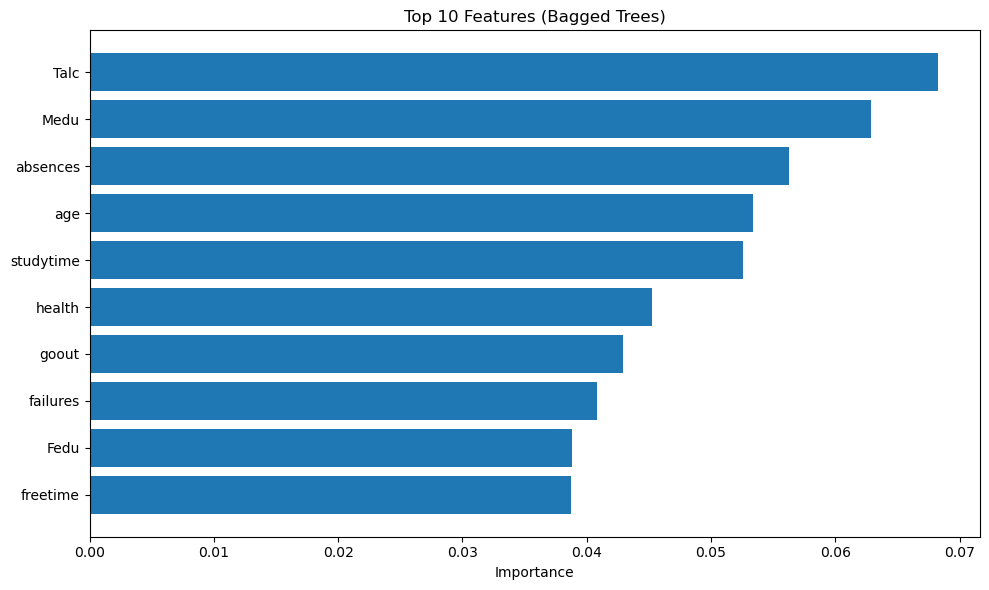

Bagged Trees Balanced Acc: 0.5989


In [ ]:
# FULL FEATURE SET (not Talc-only)
X_all = df.drop(columns=[c for c in ["G3","G1","G2","good_perf","bad_perf","passed"] if c in df.columns])
y_all = df["good_perf"].copy()

# sanity: no leakage columns left in X
assert all(c not in X_all.columns for c in ["G1","G2","G3","good_perf","bad_perf","passed"])

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    verbose_feature_names_out=False
)

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

# validation split for pruning selection (keep test clean)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# standard tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))

# cost-complexity pruning: choose alpha on validation split
path = dt.cost_complexity_pruning_path(X_tr2, y_tr2)
ccp_alphas = path.ccp_alphas[:-1] if len(path.ccp_alphas) > 1 else path.ccp_alphas

best_alpha, best_acc = 0, -1
for a in ccp_alphas:
    m = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    m.fit(X_tr2, y_tr2)
    acc = accuracy_score(y_val2, m.predict(X_val2))
    if acc > best_acc:
        best_acc, best_alpha = acc, a

dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
dt_pruned.fit(X_train, y_train)
acc_pruned = accuracy_score(y_test, dt_pruned.predict(X_test))

# bagging
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
bag.fit(X_train, y_train)
acc_bag = accuracy_score(y_test, bag.predict(X_test))

baseline_acc = y_test.value_counts(normalize=True).max()

print("FULL MODEL RESULTS (all predictors)")
print(f"Baseline (Always predict majority class): {baseline_acc:.4f}")
print(f"Standard Tree Accuracy:                   {acc_dt:.4f}")
print(f"Pruned Tree Accuracy:                     {acc_pruned:.4f} (alpha={best_alpha:.5f})")
print(f"Bagged Trees Accuracy:                    {acc_bag:.4f}")

# feature importance from bagged trees (average across estimators)
feature_names = preprocessor.get_feature_names_out()
bag_importances = np.mean([tree.feature_importances_ for tree in bag.estimators_], axis=0)

df_imp = (
    pd.DataFrame({"feature": feature_names, "importance": bag_importances})
      .sort_values("importance", ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
plt.title("Top 10 Features (Bagged Trees)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

from sklearn.metrics import balanced_accuracy_score
print(f"Bagged Trees Balanced Acc: {balanced_accuracy_score(y_test, bag.predict(X_test)):.4f}")



## Part 3: Training Dynamics and Loss Curve

To monitor our neural network's stability and detect potential overfitting, we tracked log loss over 60 training epochs using a held-out validation split derived from the training data. Because accuracy alone can obscure training dynamics, log loss provides a more sensitive view of whether predicted probabilities are improving in a calibrated way over time.

The gap between the curves is crucial - if the training loss continues to decrease while the validation loss either plateaus or increases, that pattern is consistent with overfitting. If both losses decrease together and remain close to each other, it suggests the model is learning patterns that transfer beyond the training data.

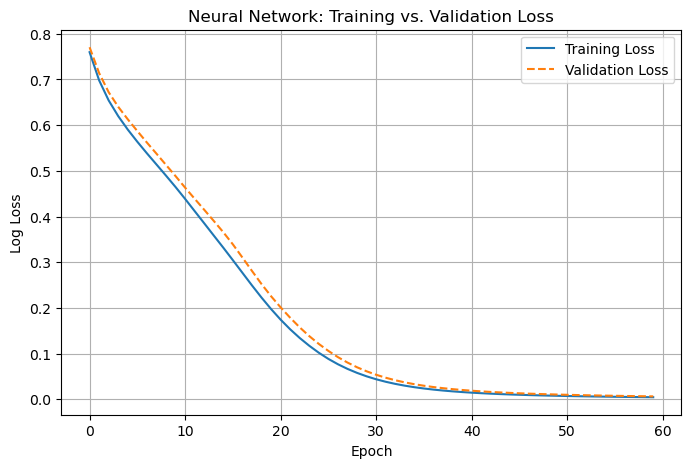

In [ ]:
# Split train into train/validation to keep test clean
X_tr_scaled, X_val_scaled, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Neural Network with Loss Tracking
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Training Loop
train_losses, val_losses = [], []
epochs = 60
classes = np.unique(y_tr)

for e in range(epochs):
    mlp.partial_fit(X_tr_scaled, y_tr, classes=classes)

    p_train = mlp.predict_proba(X_tr_scaled)
    p_val   = mlp.predict_proba(X_val_scaled)

    train_losses.append(log_loss(y_tr, p_train))
    val_losses.append(log_loss(y_val, p_val))

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Neural Network: Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("graphs/nn_loss_curve.png", bbox_inches="tight")
plt.show()


## 4. Discussion and Findings

### Qualitative insights from text mining
The word clouds are dominated by repeated categorical levels, such as `guardian_mother`, `reason_course`, and standard parental job labels (such as `Mjob_services`). Because the corpus is built from `column_value` tokens, these visuals are best interpreted as a frequency summary of coded background labels, not deeper natural-language "themes."

Stratifying by performance is more informative than looking at the overall cloud. The lower-performing group shows a higher prevalence of disengagement and low-support tokens (notably activities_no and schoolsup_no), while the higher-performing group shows comparatively more extracurricular participation (activities_yes). Taken together, this suggests the broader family and school-choice context is relatively consistent across students, while engagement-related variables may be stronger differentiators of high performance (G3 ≥ 14) than demographics alone.

### Model performance and value
On the held-out test set, both the Neural Network and the Decision Tree achieved an accuracy of 0.7000. This matches the baseline accuracy, indicating that distinguishing top-tier students using only demographic data is difficult without knowing their previous grades.
However, the training dynamics provides an important caveat - the loss curve showed validation loss flattening while training loss continued to decrease. Essentially, after a certain point, the model kept improving on the training data without meaningfully improving on the held-out data - and this is consistent with diminishing returns and a rising risk of overfitting.

### Conclusion
Overall, the neural network performed identically to the shallow decision tree in this split, with neither model managing to beat the majority-class baseline. The loss dynamics highlight that while the network began to learn, it quickly plateaued. Since the neural network did not demonstrate superior accuracy here, its 'black box' nature makes it less attractive than the transparent decision tree for this specific task. In stakeholder-facing settings where explainability matters, having interpretable baselines (like pruned decision trees or logistic regression) is still essential because they're easier to debug and explain, even at the cost of some predictive precision.

Connecting back to alcohol use, our feature importance analysis indicates that alcohol consumption is a lower-priority predictor compared to academic history (failures) and engagement (absences). It does not appear in the top 10 most important features, suggesting it is a weak standalone signal for high academic performance.

In practice, this means that screening students based solely on alcohol use would likely generate a lot of false positives. A more effective approach would be to treat alcohol as one piece of a broader profile, alongside student engagement and support indicators that stand out in the stratified word clouds. This would help us to identify more at-risk patterns, striving for a balance between accuracy and interpretability that could hold up in a real-world educational decision-making.
